In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras import backend as K

2024-08-19 00:28:09.731086: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-19 00:28:09.793742: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 00:28:10.478757: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Carrega a base de dados a partir de seu caminho
data = np.load('dataset.npz', allow_pickle=True)
X = data['X_train']
y = data['y_train']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Scale
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [4]:
def weighted_binary_crossentropy(alpha, beta):
    def loss(y_true, y_pred):
        # Clip predictions to prevent log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Compute the loss
        loss = - (alpha * y_true * K.log(y_pred)) - (beta * (1 - y_true) * K.log(1 - y_pred))
        return K.mean(loss)
    
    return loss

In [5]:
#Model
initializer = keras.initializers.GlorotNormal(seed=12227)

inputs = keras.layers.Input(shape=(X_test_sc.shape[1],))

n = 128
H = keras.layers.Dense(units=n, activation='relu', kernel_initializer=initializer)(inputs)
shortcut = H
H = keras.layers.Dense(units=n*2, activation='relu', kernel_initializer=initializer)(H)
H = keras.layers.Dense(units=n*4, activation='relu', kernel_initializer=initializer)(H)
H = keras.layers.Dense(units=n*8, activation='relu', kernel_initializer=initializer)(H)
H = keras.layers.Dense(units=n*4, activation='relu', kernel_initializer=initializer)(H)
H = keras.layers.Dense(units=n*2, activation='relu', kernel_initializer=initializer)(H)
H = keras.layers.Dense(units=n, activation='relu', kernel_initializer=initializer)(H)
H=H+shortcut
outputs = keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer=initializer)(H)

model = keras.models.Model(inputs=inputs, outputs=outputs)

2024-08-19 00:28:11.750843: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-19 00:28:11.751213: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_binary_crossentropy(1, 1), metrics=[BinaryAccuracy()])

In [7]:
def lr_schedule(epoch, lr):
    if epoch < 10:
        return 0.01
    elif epoch < 20:
        return 0.001
    elif epoch < 30:
        return 0.0001
    else:
        return 0.0001/epoch
    
scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
    
history = model.fit(X_train_sc, y_train, epochs=50, batch_size=256, callbacks=[scheduler])

Epoch 1/50


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - binary_accuracy: 0.7439 - loss: 0.7241 - learning_rate: 0.0100
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7986 - loss: 0.4969 - learning_rate: 0.0100
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accuracy: 0.8019 - loss: 0.4923 - learning_rate: 0.0100
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.8034 - loss: 0.4850 - learning_rate: 0.0100
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.8120 - loss: 0.4765 - learning_rate: 0.0100
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.8068 - loss: 0.4847 - learning_rate: 0.0100
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - binary_accuracy: 0.8074 - loss: 0.4801 - learning_rate: 0.0100
Epoch 8/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - binary_accuracy: 0.8063 - loss: 0.4787 - learning_rate: 0.0100
Epoch 9/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - binary_accura

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


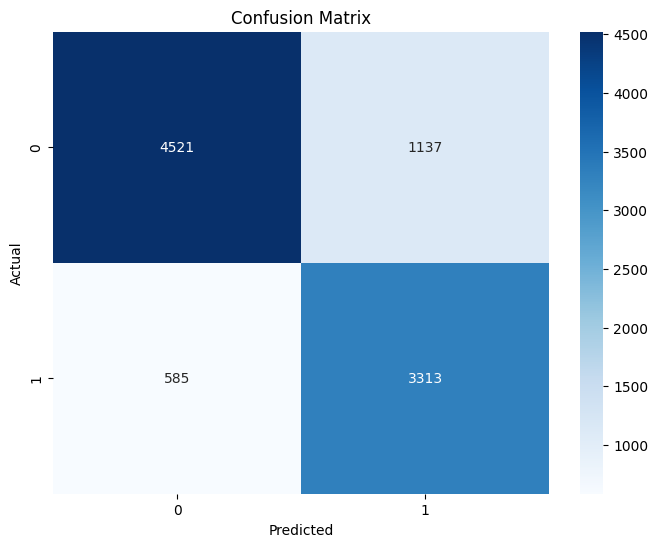

In [8]:
# Make predictions on the test set

y_pred = model.predict(X_test_sc)
y_pred_classes = (y_pred > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Evaluate the model on the test set
tn, fp, fn, tp = cm.ravel()
loss, accuracy = model.evaluate(X_test_sc, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Calcule a sensibilidade (Recall ou TPR)
sensibilidade = tp / (tp + fn)
print(f"Sensibilidade: {sensibilidade:.4f}")

# Calcule a especificidade (TNR)
especificidade = tn / (tn + fp)
print(f"Especificidade: {especificidade:.4f}")

Test Loss: 0.4692
Test Accuracy: 0.8198
Sensibilidade: 0.8499
Especificidade: 0.7990
